# Localized Entropy Notebook

This notebook runs the end-to-end pipeline using the config in `configs/default.json`.
Switch between synthetic and CTR data, tune the model, and toggle plots from the config file.


In [1]:
%matplotlib inline
import numpy as np
import torch

from localized_entropy.config import load_and_resolve, loss_label
from localized_entropy.utils import init_device, set_seed
from localized_entropy.data.pipeline import prepare_data
from localized_entropy.models import ConditionProbNet
from localized_entropy.training import train_with_epoch_plots, evaluate, predict_probs
from localized_entropy.analysis import (
    print_pred_summary,
    collect_le_stats_per_condition,
    collect_logits,
    bce_log_loss,
    roc_auc_score,
    pr_auc_score,
    expected_calibration_error,
    per_condition_metrics,
)
from localized_entropy.plotting import (
    plot_training_distributions,
    plot_eval_log10p_hist,
    plot_loss_curves,
    plot_eval_predictions_by_condition,
    plot_le_stats_per_condition,
    plot_ctr_filter_stats,
    plot_feature_distributions_by_condition,
    plot_label_rates_by_condition,
)

np.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4)

CONFIG_PATH = "configs/default.json"
cfg = load_and_resolve(CONFIG_PATH)
print(f"Using experiment: {cfg['experiment'].get('name', cfg['experiment'].get('active', 'unknown'))}")

device, use_cuda, non_blocking = init_device()
set_seed(cfg['project']['seed'], use_cuda)

def print_pred_stats_by_condition(
    preds: np.ndarray,
    conds: np.ndarray,
    num_conditions: int,
    *,
    name: str = 'Eval',
) -> None:
    p = np.asarray(preds, dtype=np.float64).reshape(-1)
    c = np.asarray(conds, dtype=np.int64).reshape(-1)
    counts = np.bincount(c, minlength=int(num_conditions))
    print(f"{name} prediction stats per condition:")
    for cond in range(int(num_conditions)):
        n = int(counts[cond])
        if n == 0:
            print(f"  cond {cond}: n=0")
            continue
        pc = p[c == cond]
        print(
            f"  cond {cond}: n={n} min={pc.min():.6g} max={pc.max():.6g} "
            f"mean={pc.mean():.6g}"
        )


Using experiment: baseline
CUDA not available, defaulting to CPU.


In [2]:
# Create reusable top-N ad-id filtered datasets + per-ad stats.
from pathlib import Path

import pandas as pd

ad_id_col = cfg["ctr"].get("condition_col", "C14")
label_col = cfg["ctr"].get("label_col", "click")
top_n = int(cfg.get("ctr", {}).get("filter_top_k", 3))
read_rows = cfg.get("ctr", {}).get("read_rows")
read_rows = int(read_rows) if read_rows else None

train_path = Path(cfg["ctr"]["train_path"])
test_path = Path(cfg["ctr"]["test_path"])

ad_id_freq_txt = Path("results/ad_id_impressions.txt")
ad_id_freq_csv = Path("results/ad_id_impressions.csv")
filtered_train_path = Path(f"data/train_top_{top_n}.csv")
filtered_test_path = Path(f"data/test_top_{top_n}.csv")

if ad_id_freq_txt.exists():
    freq_df = pd.read_csv(
        ad_id_freq_txt,
        sep=r"\s+",
        header=None,
        names=["impressions", ad_id_col],
    )
    freq_df = freq_df.sort_values("impressions", ascending=False).reset_index(drop=True)
else:
    counts = pd.Series(dtype="int64")
    for chunk in pd.read_csv(
        train_path,
        usecols=[ad_id_col],
        chunksize=1_000_000,
        nrows=read_rows,
    ):
        counts = counts.add(chunk[ad_id_col].value_counts(), fill_value=0)
    freq_df = (
        counts.astype(int)
        .sort_values(ascending=False)
        .rename("impressions")
        .reset_index()
        .rename(columns={"index": ad_id_col})
    )

ad_id_freq_csv.parent.mkdir(parents=True, exist_ok=True)
freq_df.to_csv(ad_id_freq_csv, index=False)

top_ids = freq_df.head(top_n)[ad_id_col].tolist()
print(f"Top {top_n} {ad_id_col} values by impressions: {top_ids}")

def filter_to_ids(input_path: Path, output_path: Path, ids: list[int]) -> int:
    output_path.parent.mkdir(parents=True, exist_ok=True)
    wrote = False
    row_count = 0
    for chunk in pd.read_csv(input_path, chunksize=1_000_000, nrows=read_rows):
        filtered = chunk[chunk[ad_id_col].isin(ids)]
        if filtered.empty:
            continue
        row_count += len(filtered)
        filtered.to_csv(
            output_path,
            mode="w" if not wrote else "a",
            header=not wrote,
            index=False,
        )
        wrote = True
    if not wrote:
        pd.read_csv(input_path, nrows=0).to_csv(output_path, index=False)
    return row_count

train_rows = filter_to_ids(train_path, filtered_train_path, top_ids)
test_rows = filter_to_ids(test_path, filtered_test_path, top_ids)

cfg["ctr"]["train_path"] = str(filtered_train_path)
if test_rows > 0:
    cfg["ctr"]["test_path"] = str(filtered_test_path)
else:
    print("[WARN] Filtered test set is empty; keeping unfiltered test rows.")
    cfg["ctr"]["test_path"] = str(test_path)

filtered_train = pd.read_csv(filtered_train_path, usecols=[ad_id_col, label_col])
stats = (
    filtered_train.groupby(ad_id_col)[label_col]
    .agg(mean="mean", std=lambda s: s.std(ddof=0), impressions="size")
    .reset_index()
)
stats["std"] = stats["std"].fillna(0.0)
epsilon = 1e-12
stats["log10_mean"] = np.log10(stats["mean"].clip(lower=epsilon))
stats = stats.sort_values("impressions", ascending=False)
print(stats[[ad_id_col, "impressions", "mean", "std", "log10_mean"]].to_string(index=False))


Top 3 C14 values by impressions: [21767, 21768, 19251]
[WARN] Filtered test set is empty; keeping unfiltered test rows.
  C14  impressions     mean      std  log10_mean
21767       376105 0.103405 0.304487   -0.985460
21768       373692 0.104319 0.305673   -0.981639
19251       339308 0.077711 0.267716   -1.109517


Loading CTR dataset...
Train rows: 1,089,105 | Test rows: 4,577,464
Filtering to top 3 values of C14: [21767, 21768, 19251]
Filtered Train rows: 1,089,105 | Filtered Test rows: 4,577,464
Train/Eval DataLoader workers: 0/0 (pin_memory=False) | Test workers: 0 | DataLoader workers disabled (set allow_dataloader_workers=true to enable).
Top-filter stats (click):
       frequency      mean       std
C14                                 
21767     376105  0.103405  0.304487
21768     373692  0.104319  0.305673
19251     339308  0.077711  0.267716


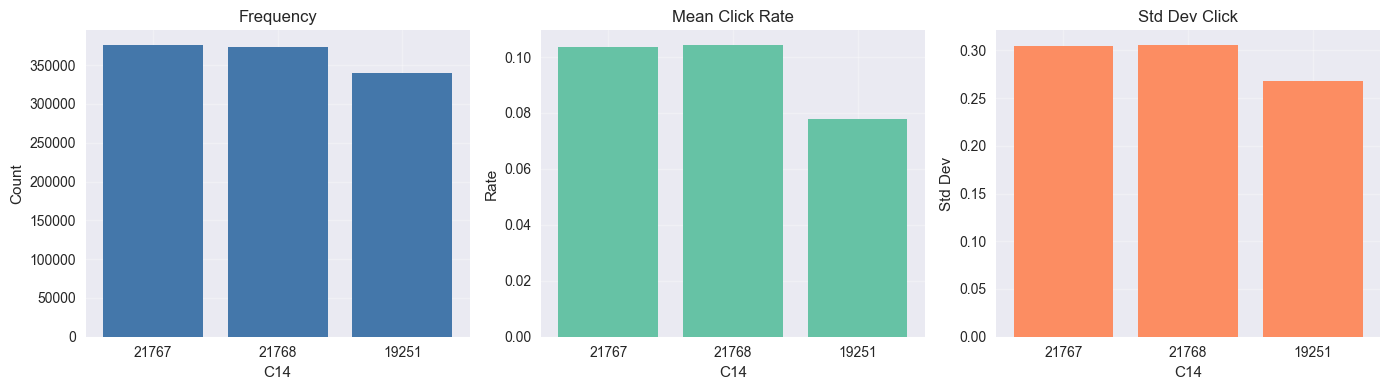

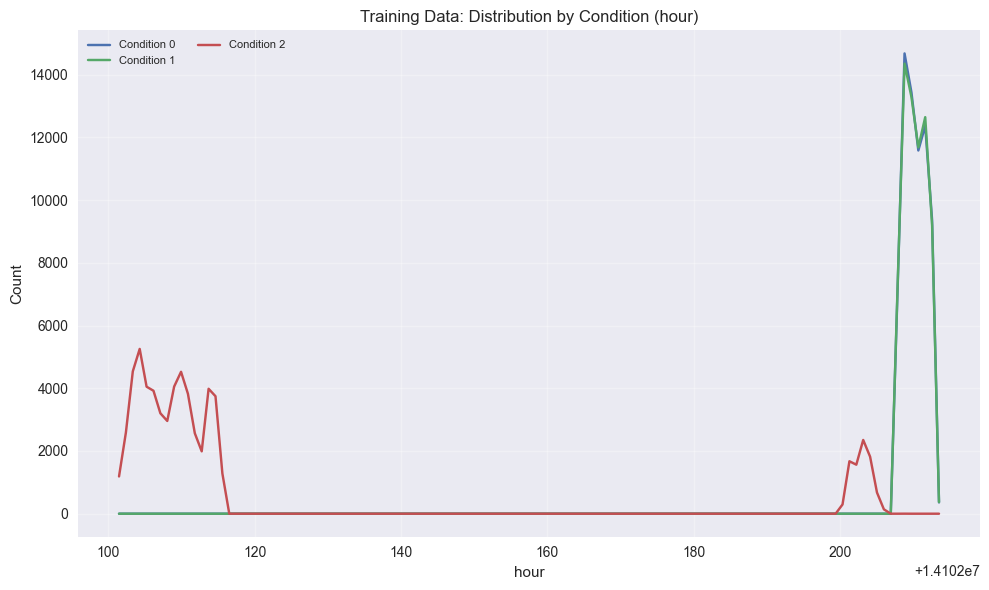

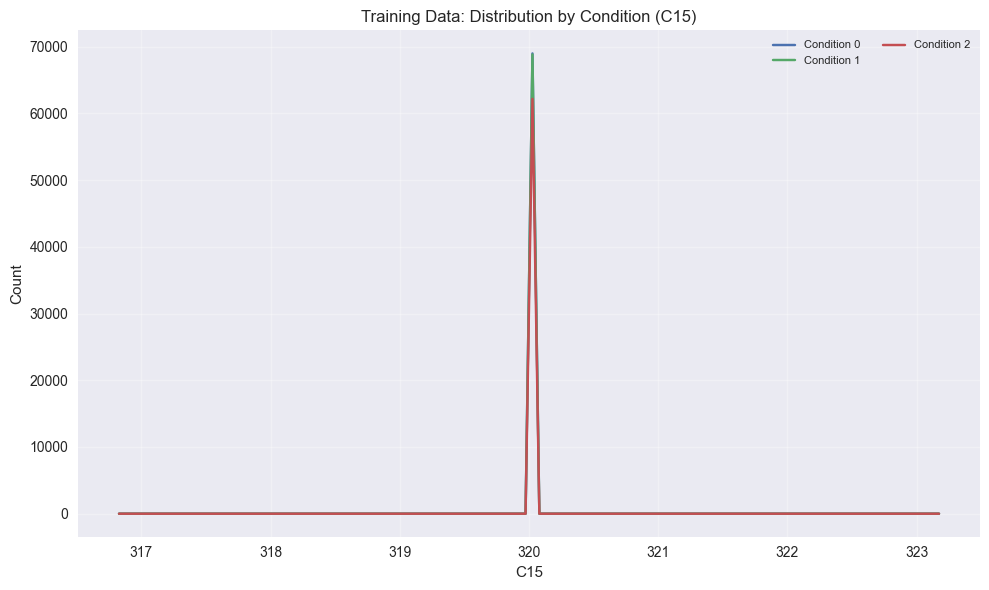

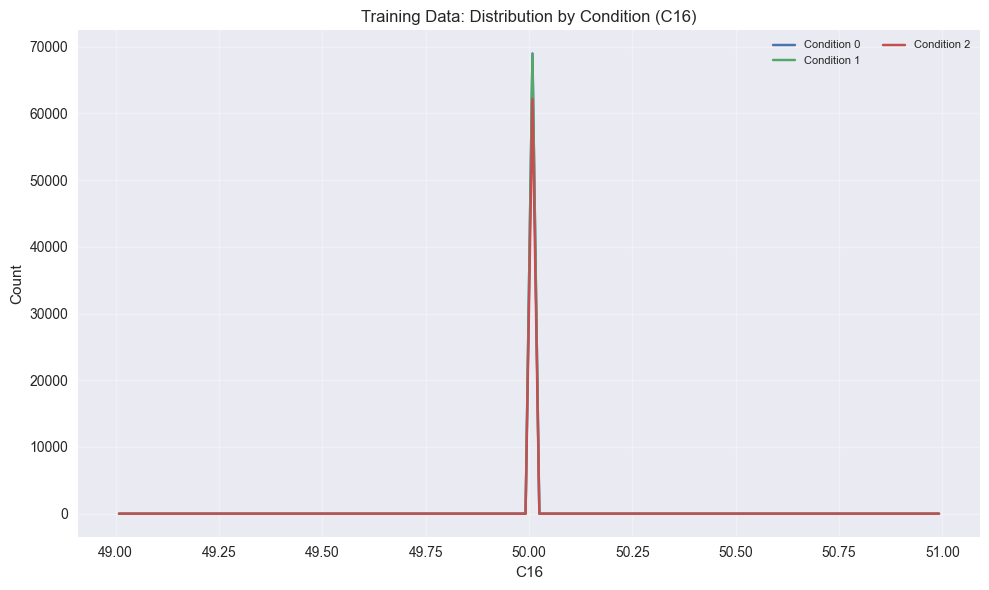

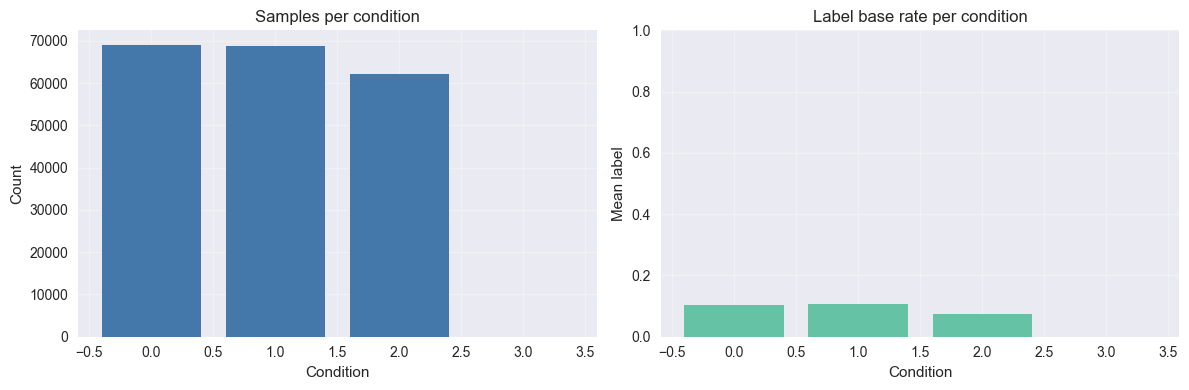

In [3]:
data_bundle = prepare_data(cfg, device, use_cuda)
splits = data_bundle.splits
loaders = data_bundle.loaders
plots_cfg = cfg['plots']
train_cfg = cfg['training']
condition_label = cfg.get('ctr', {}).get('condition_col', 'Condition')

if cfg.get('logging', {}).get('print_loader_note', True):
    print(loaders.loader_note)

if cfg.get('ctr', {}).get('plot_filter_stats', False):
    ctr_stats = data_bundle.plot_data.get('ctr_stats')
    if ctr_stats:
        plot_ctr_filter_stats(ctr_stats['stats_df'], ctr_stats['labels'], ctr_stats['filter_col'])

if plots_cfg.get('data_before_training', False):
    synth = data_bundle.plot_data.get('synthetic')
    if synth:
        plot_training_distributions(
            synth['net_worth'],
            synth['ages'],
            synth['probs'],
            synth['conds'],
            synth['num_conditions'],
        )
    else:
        if plots_cfg.get('ctr_data_distributions', True):
            ctr_plot = data_bundle.plot_data.get('ctr_distributions')
            if ctr_plot:
                log10_features = set(plots_cfg.get('ctr_log10_features', []))
                plot_feature_distributions_by_condition(
                    ctr_plot['xnum'],
                    ctr_plot['conds'],
                    ctr_plot['feature_names'],
                    ctr_plot['num_conditions'],
                    max_features=int(plots_cfg.get('ctr_max_features', 3)),
                    log10_features=log10_features,
                    density=bool(plots_cfg.get('ctr_use_density', False)),
                )
                if plots_cfg.get('ctr_label_rates', True):
                    plot_label_rates_by_condition(
                        ctr_plot['labels'],
                        ctr_plot['conds'],
                        ctr_plot['num_conditions'],
                    )
            else:
                print('CTR plot_sample_size is disabled or empty; skipping CTR distributions.')
        else:
            print('CTR distribution plots are disabled in config.')
else:
    print('Skipping training data distribution plots before training.')


In [4]:
model_cfg = cfg['model']
num_numeric = splits.x_train.shape[1]
model = ConditionProbNet(
    num_conditions=splits.num_conditions,
    num_numeric=num_numeric,
    embed_dim=model_cfg['embed_dim'],
    hidden_sizes=tuple(model_cfg['hidden_sizes']),
    p_drop=model_cfg['dropout'],
).to(device)
model


ConditionProbNet(
  (embedding): Embedding(4, 16)
  (net): Sequential(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

Pre-Training (BCE) prediction stats per condition:
  cond 0: n=37559 min=0.537078 max=0.537401 mean=0.537277
  cond 1: n=37186 min=0.531582 max=0.532745 mean=0.532031
  cond 2: n=34166 min=0.534566 max=0.535554 mean=0.534785
  cond 3: n=0
Eval predictions per condition: [37559, 37186, 34166, 0]
Conditions with zero eval samples: [3]


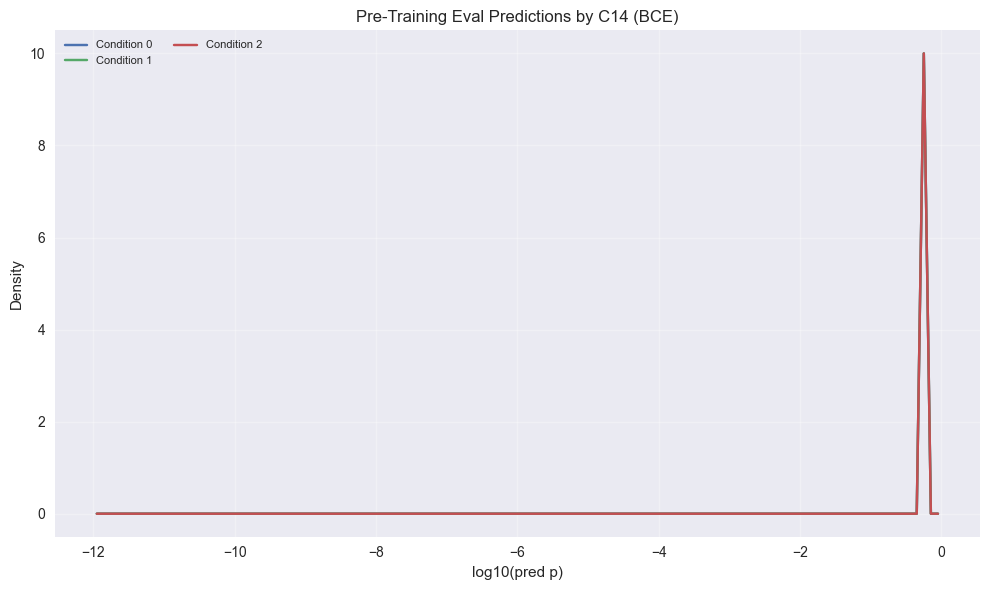

In [5]:
loss_name = loss_label(train_cfg['loss_mode'])
if plots_cfg.get('eval_pred_by_condition', True):
    pretrain_eval_preds = predict_probs(
        model,
        loaders.eval_loader,
        device,
        non_blocking=non_blocking,
    )
    if pretrain_eval_preds.size > 0:
        print_pred_stats_by_condition(
            pretrain_eval_preds,
            splits.c_eval,
            splits.num_conditions,
            name=f"Pre-Training ({loss_name})",
        )
        plot_eval_predictions_by_condition(
            pretrain_eval_preds,
            splits.c_eval,
            splits.num_conditions,
            title=(
                f"Pre-Training Eval Predictions by {condition_label} ("
                f"{loss_name})"
            ),
        )
    else:
        print('Eval set is empty after filtering; skipping pre-training plot.')


In [7]:
train_losses, eval_losses = train_with_epoch_plots(
    model=model,
    train_loader=loaders.train_loader,
    val_loader=loaders.eval_loader,
    device=device,
    epochs=train_cfg['epochs'],
    lr=train_cfg['lr'],
    l2_weight_decay=train_cfg['l2_weight_decay'],
    non_blocking=non_blocking,
    plot_eval_hist_epochs=plots_cfg.get('eval_hist_epochs', False),
    loss_mode=train_cfg['loss_mode'],
)


Epoch   1/12 | Train BCE: 0.403198 | Eval BCE: 0.312099 | wall 10.01s
Epoch   2/12 | Train BCE: 0.325972 | Eval BCE: 0.309733 | wall 10.21s
Epoch   3/12 | Train BCE: 0.323427 | Eval BCE: 0.309698 | wall 10.09s
Epoch   4/12 | Train BCE: 0.321807 | Eval BCE: 0.310461 | wall 10.09s
Epoch   5/12 | Train BCE: 0.320987 | Eval BCE: 0.309718 | wall 9.82s
Epoch   6/12 | Train BCE: 0.320365 | Eval BCE: 0.309681 | wall 9.91s
Epoch   7/12 | Train BCE: 0.320168 | Eval BCE: 0.310569 | wall 9.80s
Epoch   8/12 | Train BCE: 0.320032 | Eval BCE: 0.309689 | wall 9.92s
Epoch   9/12 | Train BCE: 0.319744 | Eval BCE: 0.309781 | wall 9.92s
Epoch  10/12 | Train BCE: 0.319495 | Eval BCE: 0.309711 | wall 9.98s
Epoch  11/12 | Train BCE: 0.319595 | Eval BCE: 0.309689 | wall 10.21s
Epoch  12/12 | Train BCE: 0.319492 | Eval BCE: 0.309591 | wall 9.95s
Final Train BCE: 0.3194917345
Final Eval  BCE: 0.3095912021


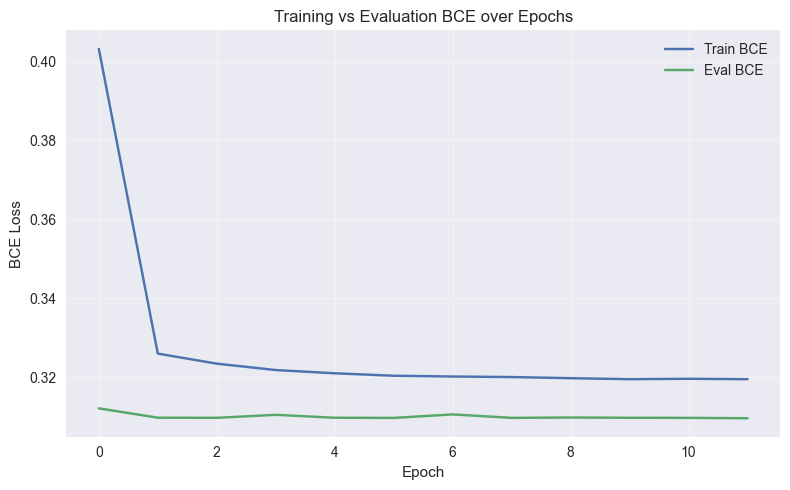

In [8]:
label = loss_label(train_cfg['loss_mode'])
if plots_cfg.get('loss_curves', True):
    plot_loss_curves(train_losses, eval_losses, label)


Eval prediction summary:
  n=108,911 mean=0.094241 std=0.017640
  min=0.037388 p01=0.037411 p05=0.037449 p50=0.091858 p95=0.108205 p99=0.108205 max=0.108205
  label base_rate=0.094077 | logloss=0.309591 | brier=0.084903 | acc@0.5=0.905923
  Top 8 conditions by count:
      count  pred_mean  label_mean
cond                              
0     37559   0.101716    0.102292
1     37186   0.101564    0.101813
2     34166   0.078052    0.076626


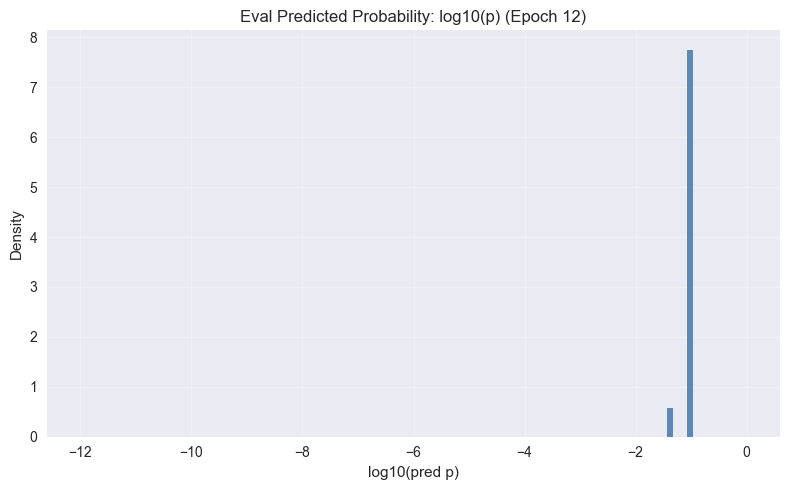

Eval predictions per condition: [37559, 37186, 34166, 0]
Conditions with zero eval samples: [3]


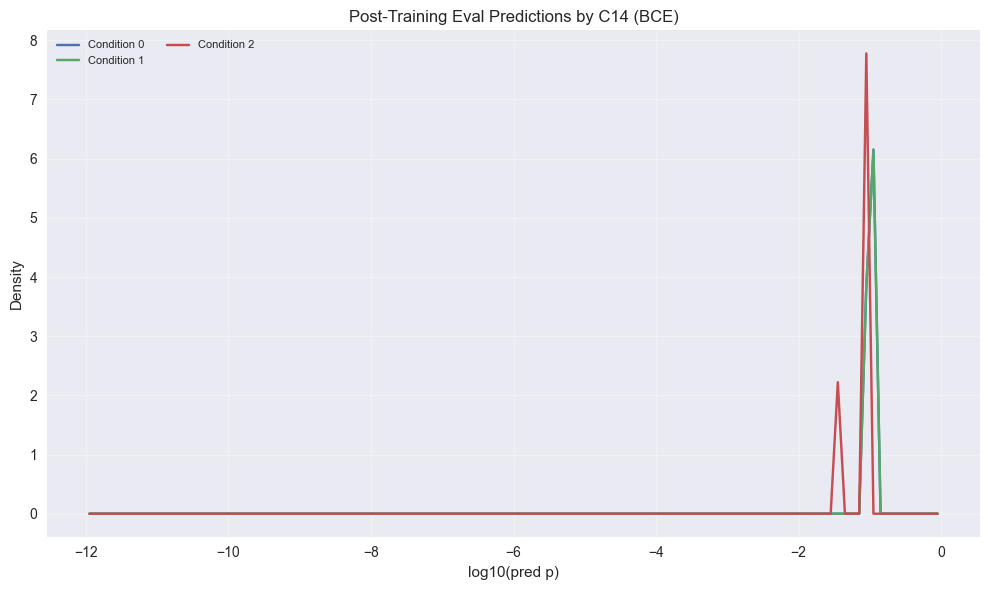

Final Evaluation BCE: 0.3095912021
[INFO] No preds <= 0.01; using 0.10 quantile threshold 0.0896492 for small-prob calibration.
Total BCE (log loss): 0.30959122
Total ECE: 0.00041257
Total ECE (small p<= 0.0896492): 0.01277030
Total ROC-AUC: 0.55182184
Total PR-AUC (AP): 0.10830526
 condition  count  base_rate      bce      ece  ece_small
         0  37559   0.102292 0.329682 0.000577        NaN
         1  37186   0.101813 0.328926 0.002267        NaN
         2  34166   0.076626 0.266461 0.001426    0.01277
Final Evaluation LE: 0.0001370307


In [9]:
eval_loss, eval_preds = evaluate(
    model,
    loaders.eval_loader,
    device,
    loss_mode=train_cfg['loss_mode'],
    non_blocking=non_blocking,
)
if plots_cfg.get('print_eval_summary', True):
    print_pred_summary('Eval', eval_preds, labels=splits.y_eval, conds=splits.c_eval)

if plots_cfg.get('eval_pred_hist', True):
    plot_eval_log10p_hist(eval_preds.astype(np.float32), epoch=train_cfg['epochs'])

if plots_cfg.get('eval_pred_by_condition', True):
    plot_eval_predictions_by_condition(
        eval_preds,
        splits.c_eval,
        splits.num_conditions,
        title=(
            f"Post-Training Eval Predictions by {condition_label} ("
            f"{label})"
        ),
    )

print(f"Final Evaluation {label}: {eval_loss:.10f}")
eval_cfg = cfg.get('evaluation', {})
bins = int(eval_cfg.get('ece_bins', 20))
min_count = int(eval_cfg.get('ece_min_count', 1))
small_prob_max_cfg = float(eval_cfg.get('small_prob_max', 0.01))
small_prob_quantile = float(eval_cfg.get('small_prob_quantile', 0.1))

total_bce = bce_log_loss(eval_preds, splits.y_eval)
total_ece, total_ece_table = expected_calibration_error(
    eval_preds, splits.y_eval, bins=bins, min_count=min_count
)
small_threshold = small_prob_max_cfg
small_mask = eval_preds <= small_threshold
if not small_mask.any():
    quantile_threshold = float(np.quantile(eval_preds, small_prob_quantile))
    print(
        f"[INFO] No preds <= {small_threshold:g}; using {small_prob_quantile:.2f} quantile "
        f"threshold {quantile_threshold:g} for small-prob calibration."
    )
    small_threshold = quantile_threshold
    small_mask = eval_preds <= small_threshold

if small_mask.any():
    total_ece_small, _ = expected_calibration_error(
        eval_preds[small_mask],
        splits.y_eval[small_mask],
        bins=bins,
        min_count=min_count,
    )
else:
    total_ece_small = float('nan')

print(f"Total BCE (log loss): {total_bce:.8f}")
print(f"Total ECE: {total_ece:.8f}")
print(f"Total ECE (small p<= {small_threshold:g}): {total_ece_small:.8f}")
total_auc = roc_auc_score(eval_preds, splits.y_eval)
total_pr_auc = pr_auc_score(eval_preds, splits.y_eval)
print(f"Total ROC-AUC: {total_auc:.8f}")
print(f"Total PR-AUC (AP): {total_pr_auc:.8f}")

if eval_cfg.get('print_calibration_table', False):
    print(total_ece_table.to_string(index=False))

per_ad = per_condition_metrics(
    eval_preds,
    splits.y_eval,
    splits.c_eval,
    bins=bins,
    min_count=min_count,
    small_prob_max=small_threshold,
)
if eval_cfg.get('print_per_ad', True):
    top_k = int(eval_cfg.get('per_ad_top_k', 10))
    print(per_ad.head(top_k).to_string(index=False))

for mode in train_cfg.get('eval_compare_losses', []):
    if mode == train_cfg['loss_mode']:
        continue
    other_loss, _ = evaluate(
        model,
        loaders.eval_loader,
        device,
        loss_mode=mode,
        non_blocking=non_blocking,
    )
    other_label = loss_label(mode)
    print(f"Final Evaluation {other_label}: {other_loss:.10f}")


In [10]:
if loaders.test_loader is not None:
    test_preds = predict_probs(
        model,
        loaders.test_loader,
        device,
        non_blocking=non_blocking,
    )
    if test_preds.size > 0:
        if plots_cfg.get('print_eval_summary', True):
            print_pred_summary('Test', test_preds, labels=None, conds=splits.c_test)
    else:
        print('Test set is empty after filtering; skipping summary.')


Test prediction summary:
  n=4,577,464 mean=0.045551 std=0.053490
  min=0.000000 p01=0.000000 p05=0.000000 p50=0.016323 p95=0.149483 p99=0.153654 max=0.175355
  Top 8 conditions by count:
        count  pred_mean
cond                    
3     4577464   0.045551


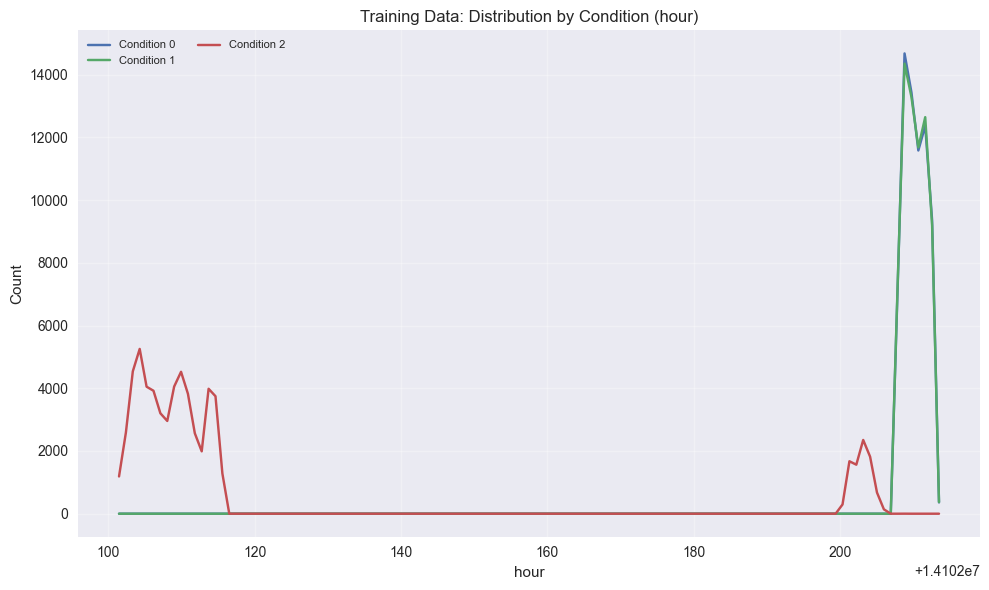

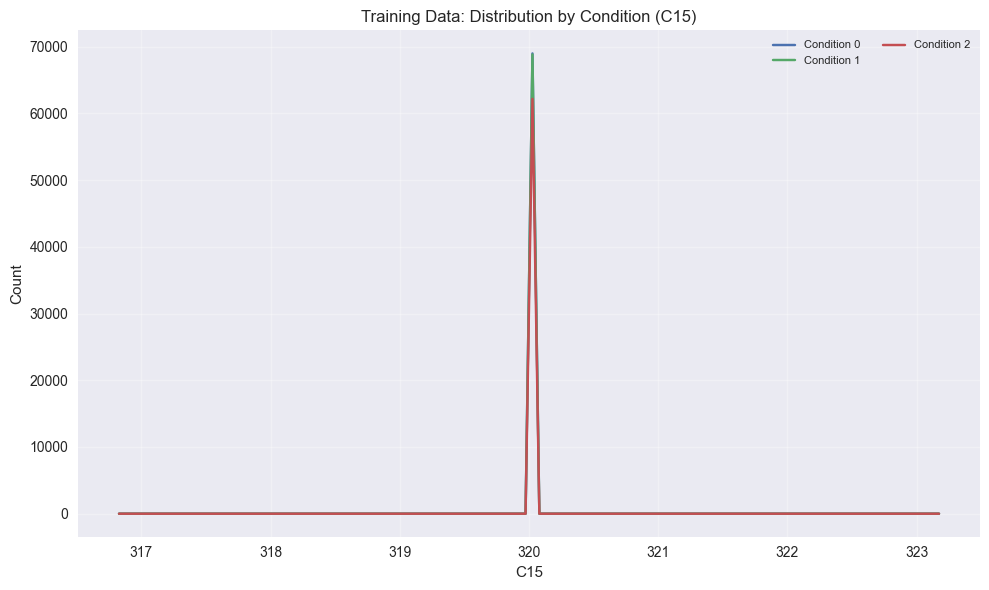

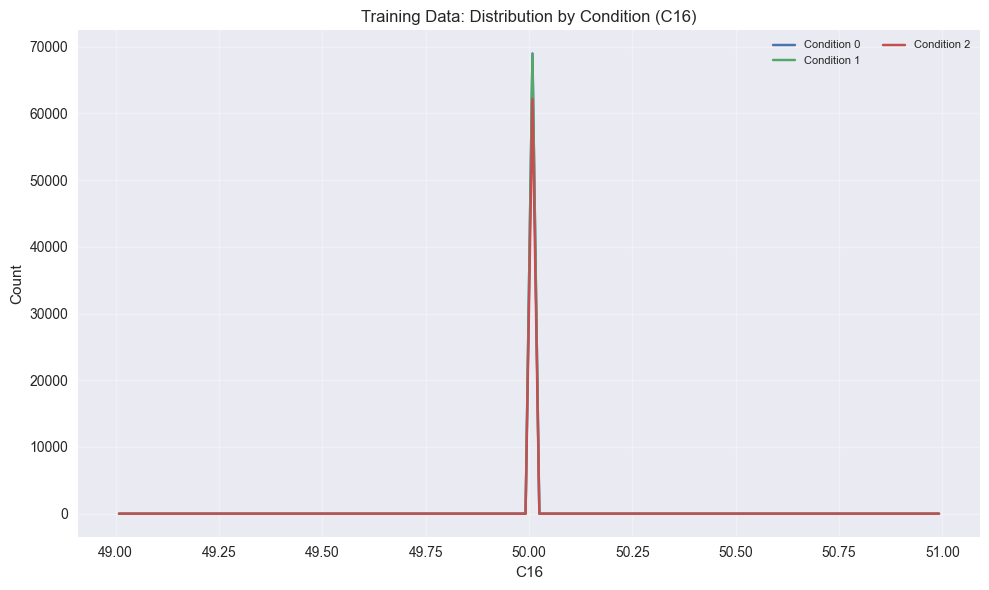

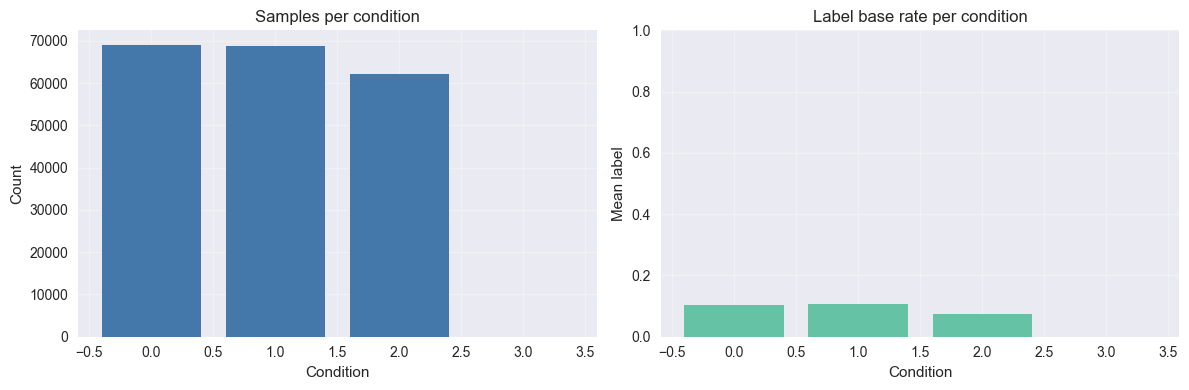

In [11]:
if plots_cfg.get('data_after_training', False):
    synth = data_bundle.plot_data.get('synthetic')
    if synth:
        plot_training_distributions(
            synth['net_worth'],
            synth['ages'],
            synth['probs'],
            synth['conds'],
            synth['num_conditions'],
        )
    else:
        if plots_cfg.get('ctr_data_distributions', True):
            ctr_plot = data_bundle.plot_data.get('ctr_distributions')
            if ctr_plot:
                log10_features = set(plots_cfg.get('ctr_log10_features', []))
                plot_feature_distributions_by_condition(
                    ctr_plot['xnum'],
                    ctr_plot['conds'],
                    ctr_plot['feature_names'],
                    ctr_plot['num_conditions'],
                    max_features=int(plots_cfg.get('ctr_max_features', 3)),
                    log10_features=log10_features,
                    density=bool(plots_cfg.get('ctr_use_density', False)),
                )
                if plots_cfg.get('ctr_label_rates', True):
                    plot_label_rates_by_condition(
                        ctr_plot['labels'],
                        ctr_plot['conds'],
                        ctr_plot['num_conditions'],
                    )
            else:
                print('CTR plot_sample_size is disabled or empty; skipping CTR post-training plots.')
        else:
            print('CTR post-training plots are disabled in config.')
else:
    print('Post-training training data plots are disabled.')


cond	num	den	avg_p	#y=1	#y=0	ratio
0	12382.5	12397.9	0.102292	3842	33717	0.998762
1	12231.4	12236	0.101813	3786	33400	0.999631
2	9103.92	9240.2	0.0766259	2618	31548	0.985251


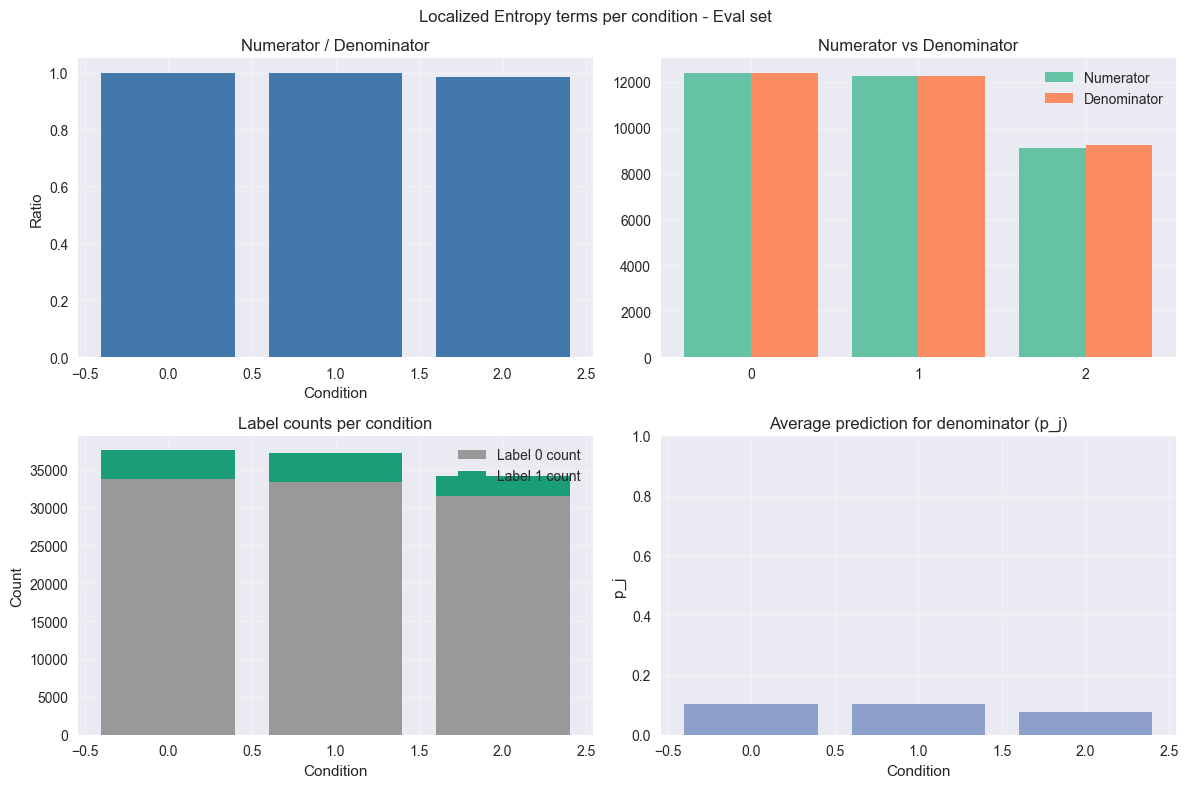

In [12]:
if plots_cfg.get('le_stats', True) or plots_cfg.get('print_le_stats_table', True):
    z_all, y_all, c_all = collect_logits(model, loaders.eval_loader, device, non_blocking=non_blocking)
    le_stats = collect_le_stats_per_condition(z_all, y_all, c_all, eps=1e-12)

    if plots_cfg.get('print_le_stats_table', True):
        print('cond	num	den	avg_p	#y=1	#y=0	ratio')
        for cond in sorted(le_stats.keys()):
            s = le_stats[cond]
            print(
                f"{cond}	{s['Numerator']:.6g}	{s['Denominator']:.6g}	"
                f"{s['Average prediction for denominator']:.6g}	"
                f"{s['Number of samples with label 1']}	"
                f"{s['Number of samples with label 0']}	"
                f"{s['Numerator/denominator']:.6g}"
            )

    if plots_cfg.get('le_stats', True):
        plot_le_stats_per_condition(le_stats, title='Localized Entropy terms per condition - Eval set')
